In [27]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import os
import subprocess # inkspace

np.random.seed(30)
# import seaborn as sns
# sns.set_style('white')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmu-serif",
    "mathtext.fontset": "cm",
    "font.size": 18
})

In [28]:
def sample_multivariate_gaussian_mixture(M, mus, sigmas, N=10000, weights=None):
    assert (M == len(mus))
    
    samples = np.zeros((N, len(mus[0]), M), dtype=np.float128)
    for i in range(M):
        samples[:, :, i] = np.random.multivariate_normal(mus[i], sigmas[i], size=(N,)).astype(np.float128)

    if weights is None:
        weights = np.ones(M, dtype=np.float128) / M
    random_idx = np.random.choice(np.arange(M), size=(N,), p=weights)
    return samples[np.arange(N), :, random_idx]

def mu1_real(y, sigma1, sigma2, Nsigma, m1, m2):
    y = y.astype(np.float128)
    mu1 = (m1 + (sigma1 @ np.linalg.inv(sigma1 + Nsigma)) @ (y - m1))
    mu2 = (m2 + (sigma2 @ np.linalg.inv(sigma2 + Nsigma)) @ (y - m2))
    
    # norm_const1 = 1 / (2* np.pi * np.linalg.det(sigma1 + Nsigma))
    # norm_const2 = 1 / (2* np.pi * np.linalg.det(sigma2 + Nsigma))

    # p1 = norm_const1 * np.diag(np.exp(-0.5 * (y - m1).T @ (sigma1 + Nsigma) @ (y - m1)))
    # p2 = norm_const2 * np.diag(np.exp(-0.5 * (y - m2).T @ (sigma2 + Nsigma) @ (y - m2)))
    p1 = np.diag(np.exp(-0.5 * (y - m1).T @ np.linalg.inv((sigma1 + Nsigma)) @ (y - m1)))
    p2 = np.diag(np.exp(-0.5 * (y - m2).T @ np.linalg.inv((sigma2 + Nsigma)) @ (y - m2)))
    
    return (mu1*p1 + mu2*p2) / (p1 + p2)

def px_pdf_real(xs, sigma1, sigma2, m1, m2):
    xs = xs.astype(np.float128)
    norm_const1 = 1 / (2* np.pi * np.linalg.det(sigma1))
    norm_const2 = 1 / (2* np.pi * np.linalg.det(sigma2))
    pdf1 = norm_const1 * np.diag(np.exp(-0.5 * (xs - m1).T @ np.linalg.inv((sigma1)) @ (xs - m1)))
    pdf2 = norm_const2 * np.diag(np.exp(-0.5 * (xs - m2).T @ np.linalg.inv((sigma2)) @ (xs - m2)))
    return 0.5 * pdf1 + 0.5 * pdf2


In [29]:
mus = [np.array([1,2]), np.array([8,10])]
sigmas = [np.array([[1, 0],[0,2]]), np.array([[2,1],[1,1]])]
x = sample_multivariate_gaussian_mixture(2, mus, sigmas, weights=np.array([0.5,0.5])).astype(np.float128)
x = x.T

noise_sigma2 = 4
sigma1, sigma2 = sigmas
m1, m2 = mus
m1 = m1.reshape(2, 1)
m2 = m2.reshape(2, 1)
Nsigma = noise_sigma2 * np.eye(2)

n = np.random.multivariate_normal(np.array([0,0]), Nsigma, (len(x.T),)).astype(np.float128).T
y = x + n


In [30]:
train_samples_x = x[:, :int(x.shape[-1] * 0.8)]
test_samples_x  = x[:, int(x.shape[-1] * 0.8):]
train_samples_y = y[:, :int(y.shape[-1] * 0.8)]
test_samples_y  = y[:, int(y.shape[-1] * 0.8):]

Text(0.5, 1.0, '$p(x)$ vs $p(x|y)$')

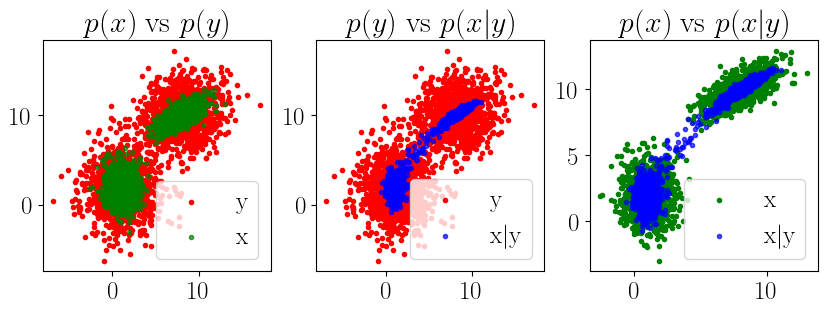

In [31]:
%matplotlib inline
mu1_real_res = mu1_real(test_samples_y, sigma1, sigma2, Nsigma, m1, m2)

plt.figure(figsize=(10,3))
plt.subplot(1, 3, 1)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
# sns.scatterplot(test_samples_y, marker='.', color='red', alpha=1, label='y')
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=0.7, label='x')
plt.legend()
plt.title('$p(x)$ vs $p(y)$')

plt.subplot(1, 3, 2)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend()
plt.title('$p(y)$ vs $p(x|y)$')

plt.subplot(1, 3, 3)
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=1, label='x')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend()
plt.title('$p(x)$ vs $p(x|y)$')

In [32]:
x_1 = np.array([4.5, 5]).reshape(2,1).astype(np.float128)
y_1 = x_1 + np.random.multivariate_normal(np.array([0,0]), Nsigma, (1,)).reshape(2,1).astype(np.float128)
y_1 = np.array([[3.5], [6.35]]).astype(np.float128)

# Using true $\mu_1(y)$ as the model

In [33]:
iters = 100
n_ev = 2
c = 1e-5

custom_ev = None
# custom_ev = np.array([[1, 0], [0,1]]).astype(np.float128)

mmse = mu1_real(y_1, sigma1, sigma2, Nsigma, m1, m2)
bmmse = np.concatenate([mmse] * n_ev, axis=1)
eigvecs = np.random.randn(*bmmse.shape).astype(np.float128)
if custom_ev is None:
    for i in range(iters):
        out = mu1_real(y_1 + eigvecs, sigma1, sigma2, Nsigma, m1, m2)
        Ab = out - mmse
        if n_ev > 1:
            norm_of_Ab = np.linalg.norm(Ab.astype(np.float64), axis=0).astype(np.float128)
            eigvecs = Ab / norm_of_Ab # Complete the power iteration
            
            # Make sure the evs are orthonormal
            Q = np.linalg.qr(eigvecs.astype(np.float64), mode='reduced')[0].astype(np.float128)
            eigvecs = Q / np.linalg.norm(Q.astype(np.float64), axis=0).astype(np.float128)
        else:
            norm_of_Ab = np.linalg.norm(Ab.astype(np.float64).ravel()).astype(np.float128)
            eigvecs = Ab / norm_of_Ab # This completes the power iteration
        eigvecs *= c
    eigvals = (norm_of_Ab / c * noise_sigma2).reshape(n_ev, )
    eigvecs /= c
else:
    eigvecs = custom_ev
    out = mu1_real(y_1 + eigvecs * c, sigma1, sigma2, Nsigma, m1, m2)
    Ab = out - mmse
    eigvals = np.linalg.norm(Ab.astype(np.float64), axis=0).astype(np.float128) / c * noise_sigma2
first_moments = eigvecs.T @ mmse
second_moments = eigvals

/tmp/ipykernel_2198984/2110027064.py:40: UserWarning: Casting input data from float128 to float64 for imshow.
  plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.pdf'), dpi=500, bbox_inches='tight')
/tmp/ipykernel_2198984/2110027064.py:41: UserWarning: Casting input data from float128 to float64 for imshow.
  plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.png'), dpi=500, bbox_inches='tight')
/tmp/ipykernel_2198984/2110027064.py:42: UserWarning: Casting input data from float128 to float64 for imshow.
  plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.svg'), dpi=500, bbox_inches='tight')
/tmp/ipykernel_2198984/2110027064.py:43: UserWarning: Casting input data from float128 to float64 for imshow.
  plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.eps'), dpi=500, bbox_inches='tight')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_2198984/2110027064.py:43: UserWarnin

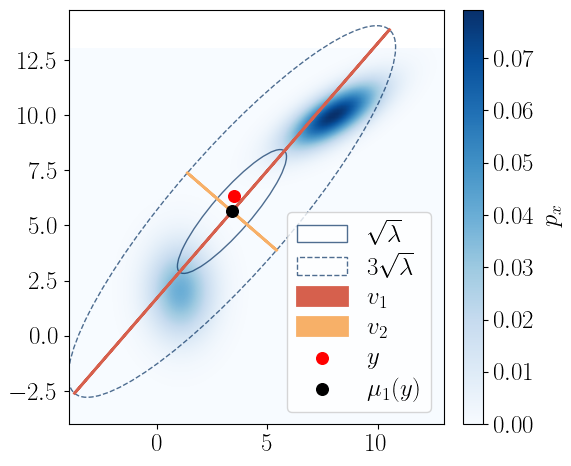

In [34]:

plt.figure(figsize=(6,5))
# plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='#fe94d0', alpha=0.6, label='samples from $p_y$', s=5)
# plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='#74add1', alpha=1, label='samples from $p_x$', s=5)
[XX, YY] = np.meshgrid(np.linspace(-4,13, 100), np.linspace(-4,13, 100))
xs = np.stack([XX.ravel(), YY.ravel()])
c = plt.imshow(px_pdf_real(xs, sigma1, sigma2, m1, m2).reshape(XX.shape), cmap='Blues', origin='lower', extent=[-4, 13, -4, 13], interpolation='bilinear')

angle = np.arctan2(eigvecs[1,0], eigvecs[0,0]) * 180 / np.pi
ellipse = patches.Ellipse((mmse[0,0], mmse[1,0]), 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', label='$\sqrt{\lambda}$')
plt.gca().add_artist(ellipse)

threesig_ellipse = patches.Ellipse((mmse[0,0], mmse[1,0]), 6 * np.sqrt(eigvals[0]), 6 * np.sqrt(eigvals[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', linestyle='--', label='$3\sqrt{\lambda}$')
plt.gca().add_artist(threesig_ellipse)

plt.arrow(mmse[0,0], mmse[1,0], eigvecs[0,0] * 3 * np.sqrt(eigvals[0]), eigvecs[1,0] * 3 * np.sqrt(eigvals[0]), head_length=0, color='#d6604d', linewidth=2, label='$v_1$')
plt.arrow(mmse[0,0], mmse[1,0], -eigvecs[0,0] * 3 * np.sqrt(eigvals[0]), -eigvecs[1,0] * 3 * np.sqrt(eigvals[0]), head_length=0, color='#d6604d', linewidth=2)
if n_ev > 1:
    plt.arrow(mmse[0,0], mmse[1,0], eigvecs[0,1] * 3 * np.sqrt(eigvals[1]), eigvecs[1,1] * 3 * np.sqrt(eigvals[1]), head_length=0, color='#f7b068', linewidth=2, label='$v_2$')
    plt.arrow(mmse[0,0], mmse[1,0], -eigvecs[0,1] * 3 * np.sqrt(eigvals[1]), -eigvecs[1,1] * 3 * np.sqrt(eigvals[1]), head_length=0, color='#f7b068', linewidth=2)
plt.scatter(y_1[0], y_1[1], marker='o', color='red', label='$y$', s=70)
plt.scatter(mmse[0], mmse[1], marker='o', color='black', label='$\mu_1(y)$', s=70)

y_up = (mmse + 3 * np.sqrt(eigvals) * eigvecs)[:,0]
y_down = (mmse - 3 * np.sqrt(eigvals) * eigvecs)[:, 0]

# plt.scatter(y_up[0], y_up[1], marker='+', color='black', label='$\mu_1(y) +3\sqrt{\lambda} v$', s=70)
# plt.scatter(y_down[0], y_down[1], marker='*', color='black', label='$\mu_1(y) -3 \sqrt{\lambda} v$', s=70)
# plt.gca().axis([test_samples_y.min(), test_samples_y.max(), test_samples_y.min(), test_samples_y.max()])
plt.colorbar(c, ax=plt.gca(), label="$p_x$", fraction=0.046, pad=0.04)

# plt.colorbar()
# plt.clabel('$p_x$')
plt.legend(loc='lower right', labelspacing=0.3)
plt.tight_layout()
ylimmin, ylimmax = plt.gca().get_ylim()
xlimmin, xlimmax = plt.gca().get_xlim()
os.makedirs('Figures', exist_ok=True)
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.pdf'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.svg'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.eps'), dpi=500, bbox_inches='tight')
subprocess.call('inkscape Figures/GMM_Example_theoretical.svg --export-type="emf"',shell=True)

plt.show()

## Derivatives

In [35]:
h=1e-5
third_moments = []
fourth_moments = []
for i in range(n_ev):
    first_term = mu1_real(y_1 + eigvecs[:, i].reshape(2,1) * 2 * h, sigma1, sigma2, Nsigma, m1, m2)
    second_term = mu1_real(y_1 + eigvecs[:, i].reshape(2,1) * h, sigma1, sigma2, Nsigma, m1, m2)
    third_term = mu1_real(y_1, sigma1, sigma2, Nsigma, m1, m2)
    fourth_term = mu1_real(y_1 - eigvecs[:, i].reshape(2,1) * h, sigma1, sigma2, Nsigma, m1, m2)
    deriv_approx = (1/(h**3)) * (first_term - 3 * second_term + 3 * third_term - fourth_term)

    fourth_moments.append((noise_sigma2 ** 3) * (eigvecs[:, i] @ deriv_approx)[0] + 3 * (second_moments[i] ** 2))

    deriv_approx = (1/(h**2)) * (second_term - 2 * third_term + fourth_term)
    third_moments.append((noise_sigma2 ** 2) * (eigvecs[:, i] @ deriv_approx)[0])

print(f'vmu1 = {first_moments[:,0]};')
print(f'vmu2 = {second_moments};')
print(f'vmu3 = {third_moments};')
print(f'vmu4 = {fourth_moments};')
print(f'noisy_sample = [{y_1[0,0]}; {y_1[1,0]}];')
print(f'mmse_sample = [{mmse[0,0]}; {mmse[1,0]}];')
print(f'real_sample = [{x_1[0,0]} {x_1[1,0]}];')
print(f'evs = {eigvecs};')

vmu1 = [-6.48116919  1.12294691];
vmu2 = [13.18738138  0.79385325];
vmu3 = [-16.608898819212904521, 0.0025148967496600755788];
vmu4 = [259.97027967134483295, 2.2254431330334105345];
noisy_sample = [3.5; 6.35];
mmse_sample = [3.395287589068289; 5.63370091783955];
real_sample = [4.5 5.0];
evs = [[-0.65481928 -0.75578549]
 [-0.75578549  0.65481928]];


## Polynomial

d1_x[0]: 13.003225933328707
d1_x[0]: 0.7938532424498383
vmu1 = [-6.48116919  1.12294691];
vmu2 = [13.18738138  0.79385325];
vmu3 = [-14.9367583099826841675, 0.0025149163612804164604];
vmu4 = [298.1971630452587029, 2.1267176680852102574];
noisy_sample = [3.5; 6.35];
mmse_sample = [3.395287589068289; 5.63370091783955];
real_sample = [4.5 5.0];
evs = [[-0.65481928 -0.75578549]
 [-0.75578549  0.65481928]];


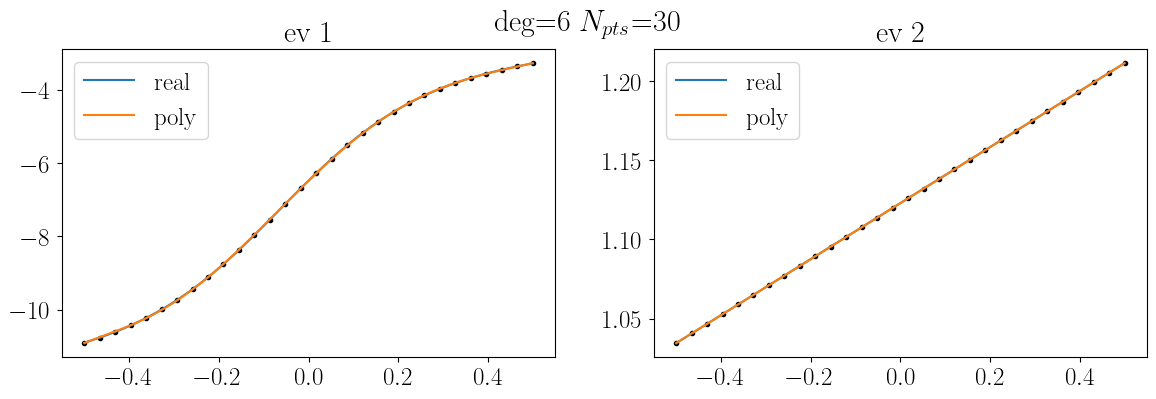

In [56]:
%notebook inline

def poly(xs, coeffs):
    deg = len(coeffs) -1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for d in range(len(coeffs)):
        value += coeffs[d] * (xs ** (deg - d))
    return value

def d1_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg):
        value += (deg - i) * coeffs[i] * (xs ** (deg - 1 - i))
    return value

def d2_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg - 1):
        value += (deg - i) * (deg - 1 - i) * coeffs[i] * (xs ** (deg - 2 - i))
    return value
    
def d3_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg - 2):
        value += (deg - i) * (deg - 1 - i) * (deg - 2 - i) * coeffs[i] * (xs ** (deg - 3 - i))
    return value


deg = 6
delta = 30
fromto = 0.5
third_moments = []
fourth_moments = []
plt.figure(figsize=(7*n_ev, 4))
for i in range(n_ev):
    poly_xs = np.linspace(-fromto, fromto,delta) * np.sqrt(second_moments[i])
    poly_ys = eigvecs[:, i] @ mu1_real(y_1 + poly_xs * eigvecs[:, i].reshape(2,1), sigma1, sigma2, Nsigma, m1, m2)

    coeffs = np.polyfit(poly_xs.astype(np.float64), poly_ys.astype(np.float64), deg=deg)

    plt.subplot(1, n_ev, i + 1)
    plt.plot(np.linspace(-fromto, fromto,delta), poly_ys, 'k.')
    poly_more_xs = np.linspace(-fromto, fromto, delta * 10) * np.sqrt(second_moments[i])
    
    realf = eigvecs[:, i] @ mu1_real(y_1 + poly_more_xs * eigvecs[:, i].reshape(2,1), sigma1, sigma2, Nsigma, m1, m2)
    plt.plot(np.linspace(-fromto, fromto,delta*10), realf, label="real")
    plt.plot(np.linspace(-fromto, fromto,delta*10), poly(poly_more_xs, coeffs), label="poly")
    plt.legend()
    plt.title(f'ev {i+1}')
    
    d1_dx = noise_sigma2 * d1_dx_poly(np.array([0], dtype=y_1.dtype), coeffs)
    print(f'd1_x[0]: {d1_dx[0]}')
    d2_dx = d2_dx_poly(np.array([0], dtype=y_1.dtype), coeffs)
    d3_dx = d3_dx_poly(np.array([0], dtype=y_1.dtype), coeffs)
    third_moments.append((noise_sigma2 ** 2) * (d2_dx)[0])
    # fourth_moments.append((noise_sigma2 ** 3) * d3_dx[0] + 3 * (second_moments[i] ** 2))
    fourth_moments.append((noise_sigma2 ** 3) * d3_dx[0] + 3 * (d1_dx[0] ** 2))

plt.suptitle(f'deg={deg} $N_{{pts}}$={delta}')
#     first_term = mu1_real(y_1 + eigvecs[:, i].reshape(2,1) * 2 * h, sigma1, sigma2, Nsigma, m1, m2)
#     second_term = mu1_real(y_1 + eigvecs[:, i].reshape(2,1) * h, sigma1, sigma2, Nsigma, m1, m2)
#     third_term = mu1_real(y_1, sigma1, sigma2, Nsigma, m1, m2)
#     fourth_term = mu1_real(y_1 - eigvecs[:, i].reshape(2,1) * h, sigma1, sigma2, Nsigma, m1, m2)
#     deriv_approx = (1/(h**3)) * (first_term - 3 * second_term + 3 * third_term - fourth_term)

#     fourth_moments.append((noise_sigma2 ** 3) * (eigvecs[:, i] @ deriv_approx)[0] + 3 * (second_moments[i] ** 2))

#     deriv_approx = (1/(h**2)) * (second_term - 2 * third_term + fourth_term)
#     third_moments.append((noise_sigma2 ** 2) * (eigvecs[:, i] @ deriv_approx)[0])

print(f'vmu1 = {first_moments[:,0]};')
print(f'vmu2 = {second_moments};')
print(f'vmu3 = {third_moments};')
print(f'vmu4 = {fourth_moments};')
print(f'noisy_sample = [{y_1[0,0]}; {y_1[1,0]}];')
print(f'mmse_sample = [{mmse[0,0]}; {mmse[1,0]}];')
print(f'real_sample = [{x_1[0,0]} {x_1[1,0]}];')
print(f'evs = {eigvecs};')

## Polynomial v2

vmu1 = [-6.48116919  1.12294691];
vmu2 = [13.18738138  0.79385325];
vmu3 = [-108.1850186733512853, 0.0019964746869605143331];
vmu4 = [-4027.1090350363256172, 2.0576072864562623653];
noisy_sample = [3.5; 6.35];
mmse_sample = [3.395287589068289; 5.63370091783955];
real_sample = [4.5 5.0];
evs = [[-0.65481928 -0.75578549]
 [-0.75578549  0.65481928]];


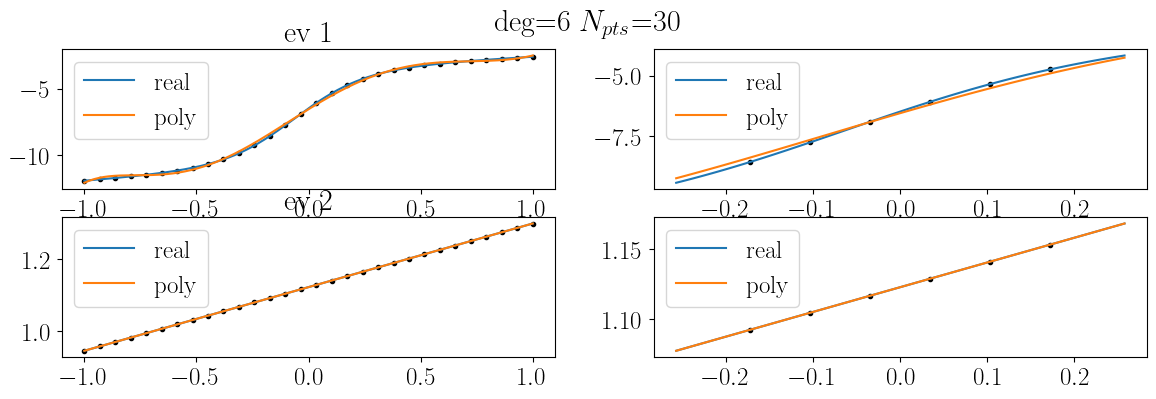

In [55]:
%notebook inline

def poly(xs, coeffs):
    deg = len(coeffs) -1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for d in range(len(coeffs)):
        value += coeffs[d] * (xs ** (deg - d))
    return value

def d1_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg):
        value += (deg - i) * coeffs[i] * (xs ** (deg - 1 - i))
    return value

def d2_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg - 1):
        value += (deg - i) * (deg - 1 - i) * coeffs[i] * (xs ** (deg - 2 - i))
    return value
    
def d3_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg - 2):
        value += (deg - i) * (deg - 1 - i) * (deg - 2 - i) * coeffs[i] * (xs ** (deg - 3 - i))
    return value


deg = 6
delta = 30
fromto = 1

h=1e-4
third_moments = []
fourth_moments = []
plt.figure(figsize=(7*n_ev, 4))
for i in range(n_ev):
    poly_xs = np.linspace(-fromto, fromto,delta) * np.sqrt(second_moments[i])
    poly_ys = eigvecs[:, i] @ mu1_real(y_1 + poly_xs * eigvecs[:, i].reshape(2,1), sigma1, sigma2, Nsigma, m1, m2)

    coeffs = np.polyfit(poly_xs.astype(np.float64), poly_ys.astype(np.float64), deg=deg)

    plt.subplot(2, n_ev, 2*i + 1)
    plt.plot(np.linspace(-fromto, fromto,delta), poly_ys, 'k.')
    poly_more_xs = np.linspace(-fromto, fromto, delta * 10) * np.sqrt(second_moments[i])
    
    realf = eigvecs[:, i] @ mu1_real(y_1 + poly_more_xs * eigvecs[:, i].reshape(2,1), sigma1, sigma2, Nsigma, m1, m2)
    plt.plot(np.linspace(-fromto, fromto,delta*10), realf, label="real")
    plt.plot(np.linspace(-fromto, fromto,delta*10), poly(poly_more_xs, coeffs), label="poly")
    plt.legend()
    plt.title(f'ev {i+1}')

    plt.subplot(2, n_ev, 2*i + 2)
    graph_len = len(np.linspace(-fromto, fromto,delta)) //5 * 2
    plt.plot(np.linspace(-fromto, fromto,delta)[graph_len:-graph_len], poly_ys[graph_len:-graph_len], 'k.')
    graph_len = len(np.linspace(-fromto, fromto,delta*10)) // 8 *3
    plt.plot(np.linspace(-fromto, fromto,delta*10)[graph_len:-graph_len], realf[graph_len:-graph_len], label="real")
    plt.plot(np.linspace(-fromto, fromto,delta*10)[graph_len:-graph_len], poly(poly_more_xs, coeffs)[graph_len:-graph_len], label="poly")
    plt.legend()

    first_term = poly(np.array([2 * h], dtype=y_1.dtype)* np.sqrt(second_moments[i]), coeffs)
    second_term = poly(np.array([h], dtype=y_1.dtype)* np.sqrt(second_moments[i]), coeffs)
    third_term = poly(np.array([0], dtype=y_1.dtype), coeffs)
    fourth_term = poly(np.array([- h], dtype=y_1.dtype)* np.sqrt(second_moments[i]), coeffs)
    deriv_approx = (1/(h**3)) * (first_term - 3 * second_term + 3 * third_term - fourth_term)

    fourth_moments.append((noise_sigma2 ** 3) * (deriv_approx[0]) + 3 * (second_moments[i] ** 2))

    deriv_approx = (1/(h**2)) * (second_term - 2 * third_term + fourth_term)
    third_moments.append((noise_sigma2 ** 2) * (deriv_approx[0]))



plt.suptitle(f'deg={deg} $N_{{pts}}$={delta}')
#     first_term = mu1_real(y_1 + eigvecs[:, i].reshape(2,1) * 2 * h, sigma1, sigma2, Nsigma, m1, m2)
#     second_term = mu1_real(y_1 + eigvecs[:, i].reshape(2,1) * h, sigma1, sigma2, Nsigma, m1, m2)
#     third_term = mu1_real(y_1, sigma1, sigma2, Nsigma, m1, m2)
#     fourth_term = mu1_real(y_1 - eigvecs[:, i].reshape(2,1) * h, sigma1, sigma2, Nsigma, m1, m2)
#     deriv_approx = (1/(h**3)) * (first_term - 3 * second_term + 3 * third_term - fourth_term)

#     fourth_moments.append((noise_sigma2 ** 3) * (eigvecs[:, i] @ deriv_approx)[0] + 3 * (second_moments[i] ** 2))

#     deriv_approx = (1/(h**2)) * (second_term - 2 * third_term + fourth_term)
#     third_moments.append((noise_sigma2 ** 2) * (eigvecs[:, i] @ deriv_approx)[0])

print(f'vmu1 = {first_moments[:,0]};')
print(f'vmu2 = {second_moments};')
print(f'vmu3 = {third_moments};')
print(f'vmu4 = {fourth_moments};')
print(f'noisy_sample = [{y_1[0,0]}; {y_1[1,0]}];')
print(f'mmse_sample = [{mmse[0,0]}; {mmse[1,0]}];')
print(f'real_sample = [{x_1[0,0]} {x_1[1,0]}];')
print(f'evs = {eigvecs};')

# And now with a Network

In [11]:
from torch import nn
import torch
from tqdm import tqdm

torch.backends.cudnn.allow_tf32 = False
torch.set_default_dtype(torch.float64)

class MMSENet(nn.Module):
    def __init__(self, hc=16, hin=1):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(hin, hc//2),
            nn.SiLU(),
            nn.Linear(hc//2, hc),
            nn.SiLU(),
            nn.Linear(hc, hc),
            nn.SiLU(),
            nn.Linear(hc, hc//2),
            nn.SiLU(),
            nn.Linear(hc//2, hin)
            )
    
    def forward(self, x):
        out = self.body(x)
        return out


In [12]:
np.random.seed(6)
torch.manual_seed(6)

HC = 200
EPOCHS = 300
LR = 0.005


mmseNet parameters: 81002


100%|██████████| 300/300 [00:04<00:00, 64.49it/s]


1.2438014797539305


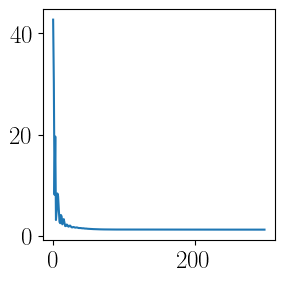

In [13]:
dev = torch.device('cuda:0')
# dev = torch.device('cpu')

torch_train_samples_x = torch.from_numpy(train_samples_x.astype(np.float64)).T.to(torch.float64).to(dev)
torch_train_samples_y = torch.from_numpy(train_samples_y.astype(np.float64)).T.to(torch.float64).to(dev)
torch_test_samples_x = torch.from_numpy(test_samples_x.astype(np.float64)).T.to(torch.float64).to(dev)
torch_test_samples_y = torch.from_numpy(test_samples_y.astype(np.float64)).T.to(torch.float64).to(dev)


mmseNet = MMSENet(hc=HC, hin=2).to(dev)
print(f'mmseNet parameters: {sum(p.numel() for p in mmseNet.parameters() if p.requires_grad)}')
mmseNet = mmseNet.to(torch.float64)
opt = torch.optim.Adam(mmseNet.parameters(), lr=LR)
# opt = torch.optim.SGD(mmseNet.parameters(), lr=0.001)
mmseNet.train()
lossf = torch.nn.MSELoss()

losses = []
for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()
    
    xhat = mmseNet(torch_train_samples_y)
    loss = lossf(xhat, torch_train_samples_x)
    
    loss.backward()
    losses.append(loss.item())
    opt.step()

mmseNet.eval()
with torch.no_grad():
    xhats = mmseNet(torch_test_samples_y).T.cpu().numpy()
    xhats_train = mmseNet(torch_train_samples_y).T.cpu().numpy()

mmseNet = mmseNet.to(torch.double)
plt.figure(figsize=(3,3))
plt.plot(losses)
print(losses[-1])

In [14]:
iters = 150
n_ev = 2
c = 1e-6

In [15]:
with torch.no_grad():
    mmse = mmseNet(torch.from_numpy(y_1.T.astype(np.float64)).to(torch.double).to(dev)).T

    bmmse = torch.concatenate([mmse] * n_ev, dim=1)
    eigvecs = torch.randn_like(bmmse, dtype=bmmse.dtype, device=dev)
    for i in range(iters):
        out = mmseNet((torch.from_numpy(y_1.astype(np.float64)).to(torch.double).to(dev) + eigvecs).T).T
        Ab = out - mmse
        if n_ev > 1:
            norm_of_Ab = Ab.norm(dim=0)
            eigvecs = Ab / norm_of_Ab # Complete the power iteration
            
            # Make sure the evs are orthonormal
            Q, _ = torch.linalg.qr(eigvecs, mode='reduced')
            eigvecs = Q / Q.norm(dim=0)
        else:
            norm_of_Ab = Ab.ravel().norm()
            eigvecs = Ab / norm_of_Ab # This completes the power iteration
        eigvecs *= c
    eigvals = (norm_of_Ab / c * noise_sigma2).reshape(n_ev, )
    eigvecs /= c
    first_moments = (eigvecs.T @ mmse)
    second_moments = eigvals

/tmp/ipykernel_2198984/110415328.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  less_proj_noncentered_xs = torch.range(first_moments[0,0] - 3.5 * torch.sqrt(second_moments[0]), first_moments[0,0] + 3.5 * torch.sqrt(second_moments[0]), 0.005, dtype=torch.float64, device=dev)


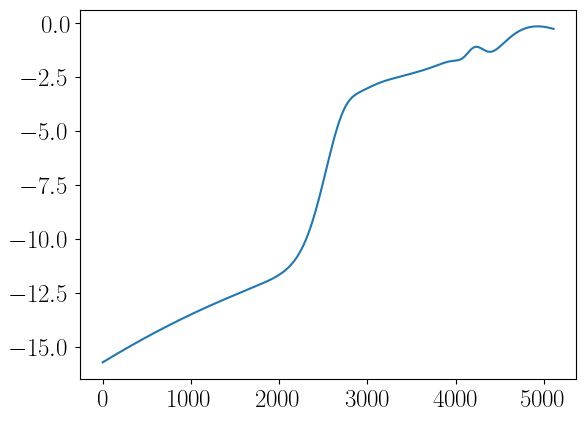

In [16]:
less_proj_noncentered_xs = torch.range(first_moments[0,0] - 3.5 * torch.sqrt(second_moments[0]), first_moments[0,0] + 3.5 * torch.sqrt(second_moments[0]), 0.005, dtype=torch.float64, device=dev)

less_xs_centered = torch.linspace(-3.5, 3.5, len(less_proj_noncentered_xs), device=dev, dtype=torch.float64) * torch.sqrt(second_moments[0])
less_xs_centered_v = eigvecs[:, 0].reshape(2,1) * less_xs_centered
less_xs = torch.from_numpy(y_1.astype(np.float64)).to(torch.double).to(dev) + less_xs_centered_v

with torch.no_grad():
    vmu1_vals_nn = (eigvecs[:, 0] @ mmseNet(less_xs.T).T).cpu().numpy()
plt.plot(vmu1_vals_nn)
from scipy.io import savemat
savemat('GMMExample/nn_vmu1_vals.mat', {'nn_vmu1_vals': vmu1_vals_nn})

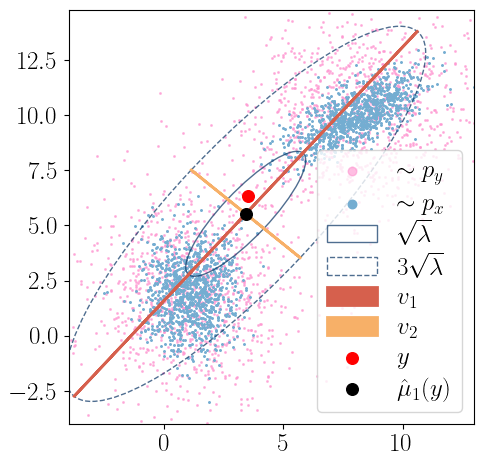

In [17]:
plt.figure(figsize=(5,5))
sc1 = plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='#fe94d0', alpha=0.6, label='$\sim p_y$', s=5)
sc2 = plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='#74add1', alpha=1, label='$\sim p_x$', s=5)
# plt.scatter(xhats_train[0], xhats_train[1], marker='.', color='red', alpha=0.2, s=5)
# plt.scatter(xhats[0], xhats[1], marker='.', color='blue', alpha=0.5, s=5)

angle = np.arctan2(eigvecs.cpu().numpy()[1,0], eigvecs.cpu().numpy()[0,0]) * 180 / np.pi
ellipse = patches.Ellipse((mmse.cpu().numpy()[0,0], mmse.cpu().numpy()[1,0]), 2 * np.sqrt(eigvals.cpu().numpy()[0]), 2 * np.sqrt(eigvals.cpu().numpy()[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', label='$\sqrt{\lambda}$')
plt.gca().add_artist(ellipse)

threesig_ellipse = patches.Ellipse((mmse.cpu().numpy()[0,0], mmse.cpu().numpy()[1,0]), 6 * np.sqrt(eigvals.cpu().numpy()[0]), 6 * np.sqrt(eigvals.cpu().numpy()[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', linestyle='--', label='$3\sqrt{\lambda}$')
plt.gca().add_artist(threesig_ellipse)

plt.arrow(mmse.cpu().numpy()[0,0], mmse.cpu().numpy()[1,0], eigvecs.cpu().numpy()[0,0] * 3 * np.sqrt(eigvals.cpu().numpy()[0]), eigvecs.cpu().numpy()[1,0] * 3 * np.sqrt(eigvals.cpu().numpy()[0]), head_length=0, color='#d6604d', linewidth=2, label='$v_1$')
plt.arrow(mmse.cpu().numpy()[0,0], mmse.cpu().numpy()[1,0], -eigvecs.cpu().numpy()[0,0] * 3 * np.sqrt(eigvals.cpu().numpy()[0]), -eigvecs.cpu().numpy()[1,0] * 3 * np.sqrt(eigvals.cpu().numpy()[0]), head_length=0, color='#d6604d', linewidth=2)
if n_ev > 1:
    plt.arrow(mmse.cpu().numpy()[0,0], mmse.cpu().numpy()[1,0], eigvecs.cpu().numpy()[0,1] * 3 * np.sqrt(eigvals.cpu().numpy()[1]), eigvecs.cpu().numpy()[1,1] * 3 * np.sqrt(eigvals.cpu().numpy()[1]), head_length=0, color='#f7b068', linewidth=2, label='$v_2$')
    plt.arrow(mmse.cpu().numpy()[0,0], mmse.cpu().numpy()[1,0], -eigvecs.cpu().numpy()[0,1] * 3 * np.sqrt(eigvals.cpu().numpy()[1]), -eigvecs.cpu().numpy()[1,1] * 3 * np.sqrt(eigvals.cpu().numpy()[1]), head_length=0, color='#f7b068', linewidth=2)
plt.scatter(y_1[0], y_1[1], marker='o', color='red', label='$y$', s=70)
plt.scatter(mmse.cpu().numpy()[0], mmse.cpu().numpy()[1], marker='o', color='black', label='$\hat{\mu}_1(y)$', s=70)

y_up = (mmse.cpu().numpy() + 3 * np.sqrt(eigvals.cpu().numpy()) * eigvecs.cpu().numpy())[:,0]
y_down = (mmse.cpu().numpy() - 3 * np.sqrt(eigvals.cpu().numpy()) * eigvecs.cpu().numpy())[:, 0]
# plt.scatter(y_up[0], y_up[1], marker='+', color='black', label='$\hat{\mu_1}(y) +3\sqrt{\lambda} v$', s=70)
# plt.scatter(y_down[0], y_down[1], marker='*', color='black', label='$\hat{\mu_1}(y) -3 \sqrt{\lambda} v$', s=70)
plt.gca().axis([test_samples_y.min(), test_samples_y.max(), test_samples_y.min(), test_samples_y.max()])
# plt.colorbar(c, ax=plt.gca(), label="$p_x$", fraction=0.046, pad=0.04)

# plt.colorbar()
# plt.clabel('$p_x$')
from matplotlib.legend_handler import HandlerPathCollection

marker_size = 150
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])

leg = plt.legend(handler_map={sc1: HandlerPathCollection(update_func=update_prop),
                              sc2: HandlerPathCollection(update_func=update_prop)}, loc='lower right', labelspacing=0.3)
# leg = plt.legend(loc='lower right', labelspacing=0.3)
plt.tight_layout()
plt.xlim(xlimmin, xlimmax)
plt.ylim(ylimmin, ylimmax)
plt.savefig(os.path.join('Figures', 'GMM_Example_NN.pdf'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_NN.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_NN.svg'), dpi=500, bbox_inches='tight')
# plt.savefig(os.path.join('Figures', 'GMM_Example_NN.eps'), dpi=500, bbox_inches='tight')
# subprocess.call('inkscape Figures/GMM_Example_NN.svg --export-type="emf"',shell=True)
plt.show()

## Derivatives

In [18]:
h4 = 1e-5
h3 = 1e-5

In [19]:

third_moments = []
fourth_moments = []
way2 = []
way3 = []
with torch.no_grad():
    for i in range(n_ev):
        first_term = mmseNet((torch.from_numpy(y_1.astype(np.float64)).to(torch.double).to(dev) + eigvecs[:, i].reshape(2,1) * 2 * h4).T).T
        second_term = mmseNet((torch.from_numpy(y_1.astype(np.float64)).to(torch.double).to(dev) + eigvecs[:, i].reshape(2,1) * h4).T).T
        third_term = mmseNet((torch.from_numpy(y_1.astype(np.float64)).to(torch.double).to(dev)).T).T
        fourth_term = mmseNet((torch.from_numpy(y_1.astype(np.float64)).to(torch.double).to(dev) - eigvecs[:, i].reshape(2,1) * h4).T).T
        deriv_approx = (1/(h4**3)) * (first_term - 3 * second_term + 3 * third_term - fourth_term)

        fourth_moments.append((noise_sigma2 ** 3) * (eigvecs[:, i] @ deriv_approx)[0] + 3 * (second_moments[i] ** 2))

        left_term = mmseNet((torch.from_numpy(y_1.astype(np.float64)).to(torch.double).to(dev) + eigvecs[:, i].reshape(2,1) * h3).T).T
        right_term = mmseNet((torch.from_numpy(y_1.astype(np.float64)).to(torch.double).to(dev) - eigvecs[:, i].reshape(2,1) * h3).T).T

        deriv_approx = (1/(h3**2)) * (left_term - 2 * third_term + right_term)
        third_moments.append((noise_sigma2 ** 2) * (eigvecs[:, i] @ deriv_approx)[0])
    
        way2.append((
            noise_sigma2 * (eigvecs[:, i].reshape(1,2) @ (mmseNet((torch.from_numpy(y_1.astype(np.float64)).to(torch.double).to(dev) + eigvecs[:, i].reshape(2,1) * c).T).T - mmse)) / c).cpu().item())
        way3.append((
            noise_sigma2 * (eigvecs[:, i].reshape(1,2) @ Ab[:, i].reshape(2,1)) / c).cpu().item())

In [20]:
third_moments = [x.cpu().item() for x in third_moments]
fourth_moments = [x.cpu().item() for x in fourth_moments]

In [21]:
print(f'vmu1 = {first_moments.cpu().numpy()[:,0]};')
print(f'vmu2 = {second_moments.cpu().numpy()};')
print(f'vmu3 = {third_moments};')
print(f'vmu4 = {fourth_moments};')
print(f'noisy_sample = [{y_1[0,0]}; {y_1[1,0]}];')
print(f'mmse_sample = [{mmse.cpu().numpy()[0,0]}; {mmse.cpu().numpy()[1,0]}];')
print(f'evs = {eigvecs.cpu().numpy()};')
print('')
print(f'way2: {way2}')
print(f'way3: {way3}')

vmu1 = [-6.41557235  1.04832296];
vmu2 = [13.33181258  1.01856775];
vmu3 = [-7.024131374944694, 1.0344291378959858];
vmu4 = [266.41617826875347, -215.2495982661103];
noisy_sample = [3.5; 6.35];
mmse_sample = [3.42131749784883; 5.527489133389139];
evs = [[-0.65653706 -0.75429377]
 [-0.75429377  0.65653706]];

way2: [13.331812581621763, 0.9758376634829838]
way3: [13.331812581621763, 0.9758376634829838]


## Polynomial

d1_x[0]: 13.33789331177872
d1_x[0]: 0.9758375262061056
vmu1 = [-6.41557235  1.04832296];
vmu2 = [13.33181258  1.01856775];
vmu3 = [-7.5266202001234390195, 1.0340467627512703874];
vmu4 = [299.65458344128959856, -2.4647810899944718993];
noisy_sample = [3.5; 6.35];
mmse_sample = [3.42131749784883; 5.527489133389139];
real_sample = [4.5 5.0];
evs = [[-0.65653706 -0.75429377]
 [-0.75429377  0.65653706]];


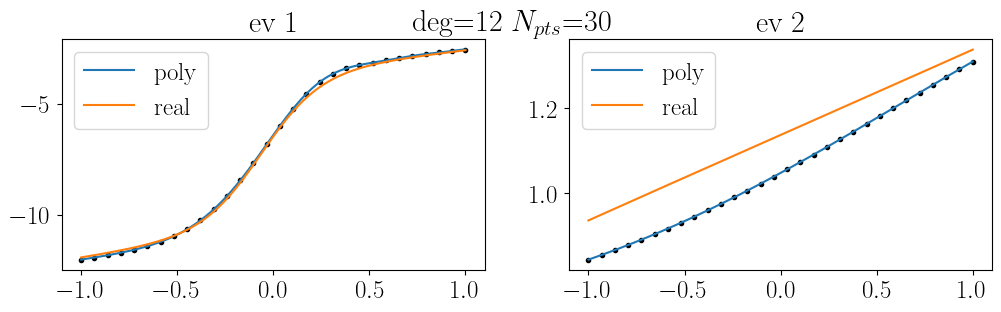

In [25]:
def poly(xs, coeffs):
    deg = len(coeffs) -1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for d in range(len(coeffs)):
        value += coeffs[d] * (xs ** (deg - d))
    return value

def d1_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg):
        value += (deg - i) * coeffs[i] * (xs ** (deg - 1 - i))
    return value

def d2_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg - 1):
        value += (deg - i) * (deg - 1 - i) * coeffs[i] * (xs ** (deg - 2 - i))
    return value
    
def d3_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg - 2):
        value += (deg - i) * (deg - 1 - i) * (deg - 2 - i) * coeffs[i] * (xs ** (deg - 3 - i))
    return value


deg = 12
delta = 30
fromto = 1

third_moments = []
fourth_moments = []
way2 = []
way3 = []
plt.figure(figsize=(6*n_ev, 3))
with torch.no_grad():
    for i in range(n_ev):
        poly_xs = torch.linspace(-fromto, fromto, delta).to(dev) * second_moments.sqrt()[i]
        poly_ys = eigvecs[:, i] @ mmseNet((torch.from_numpy(y_1.astype(np.float64)).to(torch.double).to(dev) + eigvecs[:, i].reshape(2,1) * poly_xs).T).T
        
        coeffs = np.polyfit(poly_xs.cpu().numpy(), poly_ys.cpu().numpy(), deg=deg)
        plt.subplot(1, n_ev, i + 1)
        plt.plot(np.linspace(-fromto, fromto, delta), poly_ys.cpu().numpy(), 'k.')
        poly_more_xs = np.linspace(-fromto, fromto, delta * 10) * second_moments.sqrt().cpu().numpy()[i]
        plt.plot(np.linspace(-fromto, fromto, delta*10), poly(poly_more_xs, coeffs), label='poly')
        
        realf = eigvecs.cpu().numpy()[:, i] @ mu1_real(y_1 + poly_more_xs * eigvecs.cpu().numpy()[:, i].reshape(2,1), sigma1, sigma2, Nsigma, m1, m2)
        plt.plot(np.linspace(-fromto, fromto, delta*10), realf, label='real')
        plt.title(f'ev {i+1}')
        plt.legend()

        d1_dx = noise_sigma2 * d1_dx_poly(np.array([0], dtype=y_1.dtype), coeffs)
        print(f'd1_x[0]: {d1_dx[0]}')
        d2_dx = d2_dx_poly(np.array([0], dtype=y_1.dtype), coeffs)
        d3_dx = d3_dx_poly(np.array([0], dtype=y_1.dtype), coeffs)
        third_moments.append((noise_sigma2 ** 2) * (d2_dx)[0])
        fourth_moments.append((noise_sigma2 ** 3) * d3_dx[0] + 3 * (d1_dx[0] ** 2))
        # fourth_moments.append((noise_sigma2 ** 3) * (eigvecs[:, i].cpu() @ deriv_approx)[0] + 3 * (second_moments[i] ** 2))
    
        way2.append((
            noise_sigma2 * (eigvecs[:, i].reshape(1,2) @ (mmseNet((torch.from_numpy(y_1.astype(np.float64)).to(torch.double).to(dev) + eigvecs[:, i].reshape(2,1) * c).T).T - mmse)) / c).cpu().item())
        way3.append((
            noise_sigma2 * (eigvecs[:, i].reshape(1,2) @ Ab[:, i].reshape(2,1)) / c).cpu().item())
plt.suptitle(f'deg={deg} $N_{{pts}}$={delta}')


print(f'vmu1 = {first_moments.cpu().numpy()[:,0]};')
print(f'vmu2 = {second_moments.cpu().numpy()};')
print(f'vmu3 = {third_moments};')
print(f'vmu4 = {fourth_moments};')
print(f'noisy_sample = [{y_1[0,0]}; {y_1[1,0]}];')
print(f'mmse_sample = [{mmse[0,0]}; {mmse[1,0]}];')
print(f'real_sample = [{x_1[0,0]} {x_1[1,0]}];')
print(f'evs = {eigvecs.cpu().numpy()};')

# first_moments = first_moments.cpu().numpy()
# second_moments = second_moments.cpu().numpy()
# third_moments = [x.cpu().item() for x in third_moments]
# fourth_moments = [x.cpu().item() for x in fourth_moments]
# eigvals = eigvals.cpu().numpy()
# eigvecs = eigvecs.cpu().numpy()
# mmse = mmse.cpu().numpy()

# End